# Challenge Boston Marathon

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import itertools
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist, pdist

## The Dataset

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2012/results.csv', header=None, error_bad_lines=False)

This is the data from Github and is that data from the 2012 Boston Marathon race. The URL is above. This race is 26 miles long

## Explore

In [3]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,21653,21653,21653,21653,21653,21653,21653,21653,19881,21653,21653,21653
unique,21653,21622,4976,3,66,9571,21653,21653,68,21653,9393,61
top,1081 / 4599,"Sullivan, Michael P.",Boston,M,45,-,10395,1279 / 21616,MA,4735 / 8995,245.27,USA
freq,1,2,500,12648,905,76,1,1,4030,1,11,18064


In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,division,name,city,gender,age,official,bib,overall,state,genderdiv,net,country
1,4 / 26,"Soejima, Masazumi",Fukuoka City,M,41,83.45,W1,4 / 35,NaN,4 / 26,83.45,JPN
2,14 / 4335,"Gebremariam, Gebregziabher",Tigray,M,27,142.93,2,14 / 21616,NaN,14 / 12621,142.93,ETH
3,6 / 26,"Van Dyk, Ernst F.",Paarl,M,39,84.38,W2,6 / 35,NaN,6 / 26,84.38,RSA
4,2 / 26,"Fearnley, Kurt H.",Hamilton,M,31,81.65,W3,2 / 35,NaN,2 / 26,81.65,AUS


In [5]:
df.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')

In [6]:
df.columns = ['0', '1', '2', '3', '4', '5', '6','7', '8', '9', '10', '11']

In [7]:
# dropped all catagorical variables except gender and dropped net time because I had the offical time, these two features should be nearly identical
race_df = df.drop(['6', '8', '11', '1', '2', '10'], 1)

In [8]:
# Rename columns to better identify them later
race_df.columns = ['Division', 'Gender', 'Age', 'Official', 'Overall', 'GenderDiv']

In [9]:
# Shape of dataset
race_df.shape

(21653, 6)

In [10]:
# No Nulls
null_count = race_df.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

In [11]:
# Had a few things in the dataset that would error conversions
race_df['Division'] = race_df['Division'].str.replace('/', '')
race_df['Division'] = race_df['Division'].str.replace(' ', '')
race_df['GenderDiv'] = race_df['GenderDiv'].str.replace('/', '')
race_df['GenderDiv'] = race_df['GenderDiv'].str.replace(' ', '')
race_df['Overall'] = race_df['Overall'].str.replace('/ 21616', '')
race_df['Overall'] = race_df['Overall'].str.replace(' ', '')
race_df['Overall'] = race_df['Overall'].str.replace('/35', '')
race_df['Official'] = race_df['Official'].str.replace('-', '')
race_df['Overall'] = race_df['Overall'].str.replace('/22', '')
race_df['Overall'] = race_df['Overall'].str.replace('/21', '')

In [12]:
race_df = race_df.dropna(how = 'any')

In [13]:
#dropped the top row that should have been the column names
race_df = race_df.drop(race_df.index[0])

In [14]:
race_df['Official'] = pd.to_numeric(race_df['Official'], errors='coerce')

In [15]:
race_df['Overall'] = race_df['Overall'].astype(int)
race_df['Age'] = race_df['Age'].astype(int)
race_df['Official'] = race_df['Official'].astype(float)
race_df['Division'] = race_df['Division'].astype(int)
race_df['GenderDiv'] = race_df['GenderDiv'].astype(int)

In [16]:
# much better
race_df.describe()

,Division,Age,Official,Overall,GenderDiv
count,2.165200e+04,21652.000000,21576.000000,21652.000000,2.165200e+04
mean,1.347936e+07,41.836135,262.798014,10790.559163,3.865670e+08
std,1.209416e+07,10.858308,50.383191,6250.436211,4.015488e+08
min,1.100000e+01,18.000000,78.420000,1.000000,1.900000e+01
25%,3.622196e+06,33.000000,228.645000,5377.750000,4.890650e+07
50%,1.039148e+07,42.000000,255.720000,10790.500000,1.795626e+08
75%,1.949440e+07,50.000000,290.630000,16203.250000,7.208376e+08
max,4.599460e+07,83.000000,475.320000,21616.000000,1.262113e+09


## Exploring with graphs

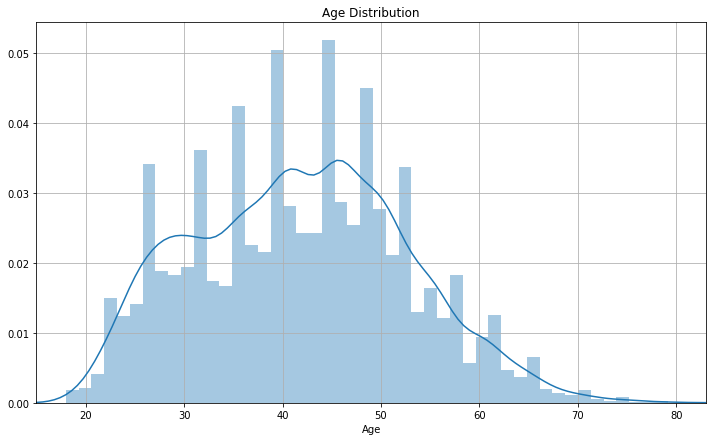

In [17]:
plt.figure(figsize=(12, 7))
sns.distplot(race_df['Age'])
plt.title('Age Distribution')
plt.xlim(15, 83)
plt.grid(True)
plt.show()

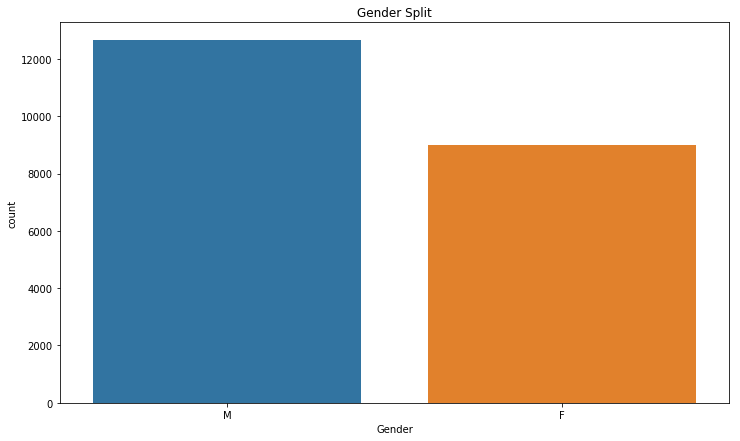

In [18]:
plt.figure(figsize=(12, 7))
sns.countplot(race_df['Gender'])
plt.title('Gender Split')
plt.show()

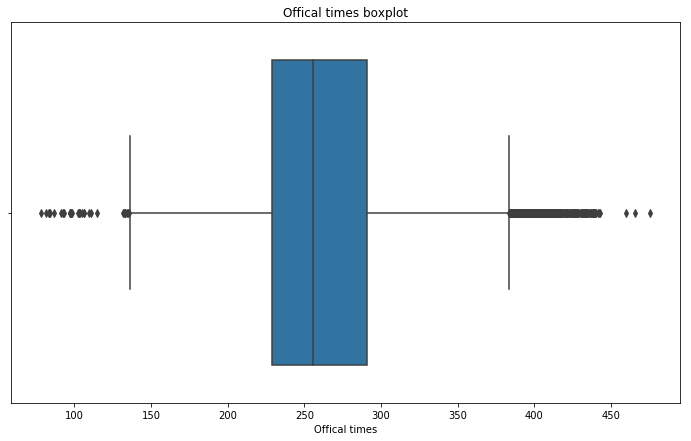

In [19]:
plt.figure(figsize=(12, 7))
sns.boxplot(race_df['Official'])
plt.title('Offical times boxplot')
plt.xlabel('Offical times')
plt.show()

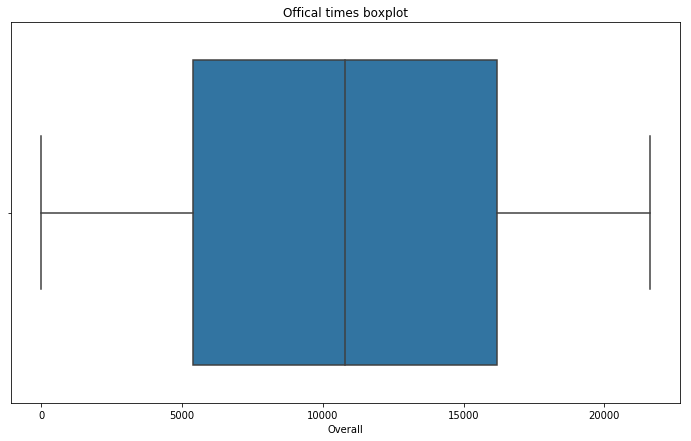

In [20]:
plt.figure(figsize=(12, 7))
sns.boxplot(race_df['Overall'])
plt.title('Offical times boxplot')
plt.show()

In [21]:
race_df['Gender']= race_df['Gender'].apply(lambda x: 1 if x == 'M' else 0)

In [22]:
X= race_df.drop(['Official'], 1)
y = race_df['Official']

In [23]:
# function for finding the best cluster number
def elbow(df, n):
    kMeansVar = [KMeans(n_clusters=k).fit(df.values) for k in range(1, n)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(df.values, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(df.values)**2)/df.values.shape[0]
    bss = tss - wcss
    plt.plot(bss)
    plt.title('best cluster amount')
    plt.grid(True)
    plt.show()

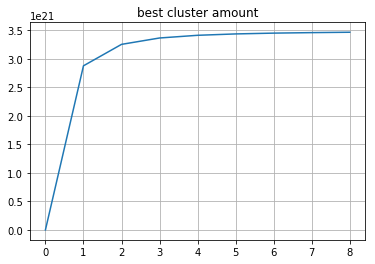

In [25]:
elbow(X, 10)

The large bends are at 1 and 2, after 5 clusters the graph shows very little difference

## KMeans

In [26]:
y_pred = KMeans(n_clusters=5).fit_predict(X)

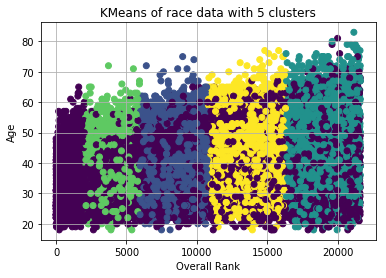

In [27]:
plt.scatter(X.values[:, 3], X.values[:, 2], c=y_pred)
plt.title('KMeans of race data with 5 clusters')
plt.xlabel('Overall Rank')
plt.ylabel('Age')
plt.grid(True)
plt.show()

In [ ]:
#Rand Index
c = list(itertools.product(y, y_pred))

# Count how often each type of pair (a, b, c, or d) appears.
RIcounts = [[x, c.count(x)] for x in set(c)]
print(RIcounts)

# Create the same counts but without the label, for easier math below.
RIcounts_nolabel = [c.count(x) for x in set(c)]

# Calculate the Rand Index.
RIscore = (RIcounts_nolabel[3] + RIcounts_nolabel[2]) / np.sum(RIcounts_nolabel)
print(RIscore)

In [ ]:
for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2, random_state=42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

## MiniBatch KMeans

In [28]:
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=5,
    batch_size=200)
minibatchkmeans.fit(X)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

Comparing k-means and mini batch k-means solutions:
col_0      0     1     2     3     4
row_0                               
0          0  2690     0   226     1
1          0     0    54     0  2674
2      10716     0     0     0     0
3        204     0     0  2479     0
4          0     0  2608     0     0


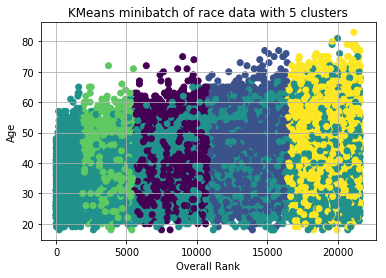

In [29]:
plt.scatter(X.values[:, 3], X.values[:, 2], c=predict_mini)
plt.title('KMeans minibatch of race data with 5 clusters')
plt.xlabel('Overall Rank')
plt.ylabel('Age')
plt.grid(True)
plt.show()

## MeanShift

In [30]:
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 6


In [ ]:
plt.scatter(X.values[:, 3], X.values[:, 2], c=labels)
plt.title('Mean-shift of race data with 6 clusters')
plt.xlabel('Overall Rank')
plt.ylabel('Age')
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y,labels))

## Conclusion

I tried KMeans and mean-shift to organize the data into clusters. I used a function to find best cluster amount and I was divided whether to use 5 or 6, I went with 5 because the amount of features was 6. The Means-Shift chose 6 clusters as its best breakdown. 